# Introduction

Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.

Logo seattle
Des relevés minutieux ont été effectués par les agents de la ville en 2016. Voici <a href="https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P4/2016_Building_Energy_Benchmarking.csv">les données</a> et <a href="https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy">leur source</a>. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)

Vous cherchez également à évaluer l’intérêt de l’"<a href="https://www.energystar.gov/buildings/benchmark/understand-metrics/score-details">ENERGY STAR Score</a>" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :

Réaliser une courte analyse exploratoire.
Tester différents modèles de prédiction afin de répondre au mieux à la problématique.
Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes et erreurs à éviter :



Douglas : L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées.. 

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée. Tu testeras au minimum 4 algorithmes de famille différente (par exemple : ElasticNet, SVM, GradientBoosting, RandomForest).

Nous traiterons dans ce notebook, la création des modèles pour notre deuxième target : la consommation du bâtiment

# Import des librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import seaborn as sns
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer,  \
                                    root_mean_squared_error, \
                                    r2_score
from sklearn.preprocessing import TargetEncoder, \
                                    StandardScaler, \
                                    MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.inspection import permutation_importance
import shap

## Chargement de seaborn

In [2]:
sns.set()

Définissons enfin une valeur de random_state qui nous sera utile dans plusieurs algorithmes pour avoir les même résultats

In [3]:
random_state = 8

# Lecture du dataset

In [4]:
buildings = pd.read_csv("./buildings_cleaned.csv")

In [5]:
buildings.head()

,Unnamed: 0,OSEBuildingID,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),...,NaturalGas,PropertyGFABuilding(s)Pct,PropertyGFAParkingPct,LargestPropertyUseTypeGFAPct,SecondLargestPropertyUseTypeGFAPct,ThirdLargestPropertyUseTypeGFAPct,BuildingType_is_campus,BuildingType_is_NonResidential,BuildingType_is_Nonresidential_COS,BuildingType_is_Nonresidential_WA
0,0,1,Hotel,47.61220,-122.33799,1927,1,12,0,88434,...,True,100.000000,0.000000,100.000000,0.000000,0.000000,0.0,1.0,0.0,0.0
1,1,2,Hotel,47.61317,-122.33393,1996,1,11,15064,88502,...,True,85.454686,14.545314,94.777519,17.021084,5.222481,0.0,1.0,0.0,0.0
2,2,3,Hotel,47.61393,-122.33810,1969,1,41,196718,759392,...,True,79.425171,20.574829,99.618247,0.000000,0.000000,0.0,1.0,0.0,0.0
3,3,5,Hotel,47.61412,-122.33664,1926,1,10,0,61320,...,True,100.000000,0.000000,100.000000,0.000000,0.000000,0.0,1.0,0.0,0.0
4,4,8,Hotel,47.61375,-122.34047,1980,1,18,62000,113580,...,True,64.688461,35.311539,108.685508,59.877619,0.000000,0.0,1.0,0.0,0.0


In [6]:
buildings.columns

Index(['Unnamed: 0', 'OSEBuildingID', 'PrimaryPropertyType', 'Latitude',
       'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions',
       'SteamUse', 'Electricity', 'NaturalGas', 'PropertyGFABuilding(s)Pct',
       'PropertyGFAParkingPct', 'LargestPropertyUseTypeGFAPct',
       'SecondLargestPropertyUseTypeGFAPct',
       'ThirdLargestPropertyUseTypeGFAPct', 'BuildingType_is_campus',
       'BuildingType_is_NonResidential', 'BuildingType_is_Nonresidential_COS',
       'BuildingType_is_Nonresidential_WA'],
      dtype='object')

Séparons tout d'abord notre dataframe en deux :
- X les features
- y les valeurs de la cible

In [7]:
X = buildings.drop(["Unnamed: 0",
    "OSEBuildingID",
    "ENERGYSTARScore",
    "SiteEnergyUseWN(kBtu)",
    "TotalGHGEmissions"], axis=1)
y = buildings["SiteEnergyUseWN(kBtu)"]

In [8]:
X.shape

(1529, 26)

In [9]:
y.shape

(1529,)

# Préparons nos données

Afin d'améliorer la performance de nos modèles, nous allons chercher à normaliser nos données.

Copions tout d'abord nos données dans un nouveau dataframe

In [11]:
X_scaled = X

Vérifions le type de nos données.

In [12]:
X_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1529 entries, 0 to 1528
Data columns (total 26 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   PrimaryPropertyType                 1529 non-null   object 
 1   Latitude                            1529 non-null   float64
 2   Longitude                           1529 non-null   float64
 3   YearBuilt                           1529 non-null   int64  
 4   NumberofBuildings                   1529 non-null   int64  
 5   NumberofFloors                      1529 non-null   int64  
 6   PropertyGFAParking                  1529 non-null   int64  
 7   PropertyGFABuilding(s)              1529 non-null   int64  
 8   LargestPropertyUseType              1529 non-null   object 
 9   LargestPropertyUseTypeGFA           1529 non-null   float64
 10  SecondLargestPropertyUseType        1529 non-null   object 
 11  SecondLargestPropertyUseTypeGFA     1529 no

Plusieurs types sont erronés, corrigeons les.

In [13]:
X_scaled = X_scaled.astype({
    "BuildingType_is_campus" : np.bool,
    "BuildingType_is_NonResidential" : np.bool,
    "BuildingType_is_Nonresidential_COS" : np.bool,
    "BuildingType_is_Nonresidential_WA" : np.bool,
})

<Axes: xlabel='ThirdLargestPropertyUseTypeGFA', ylabel='Count'>

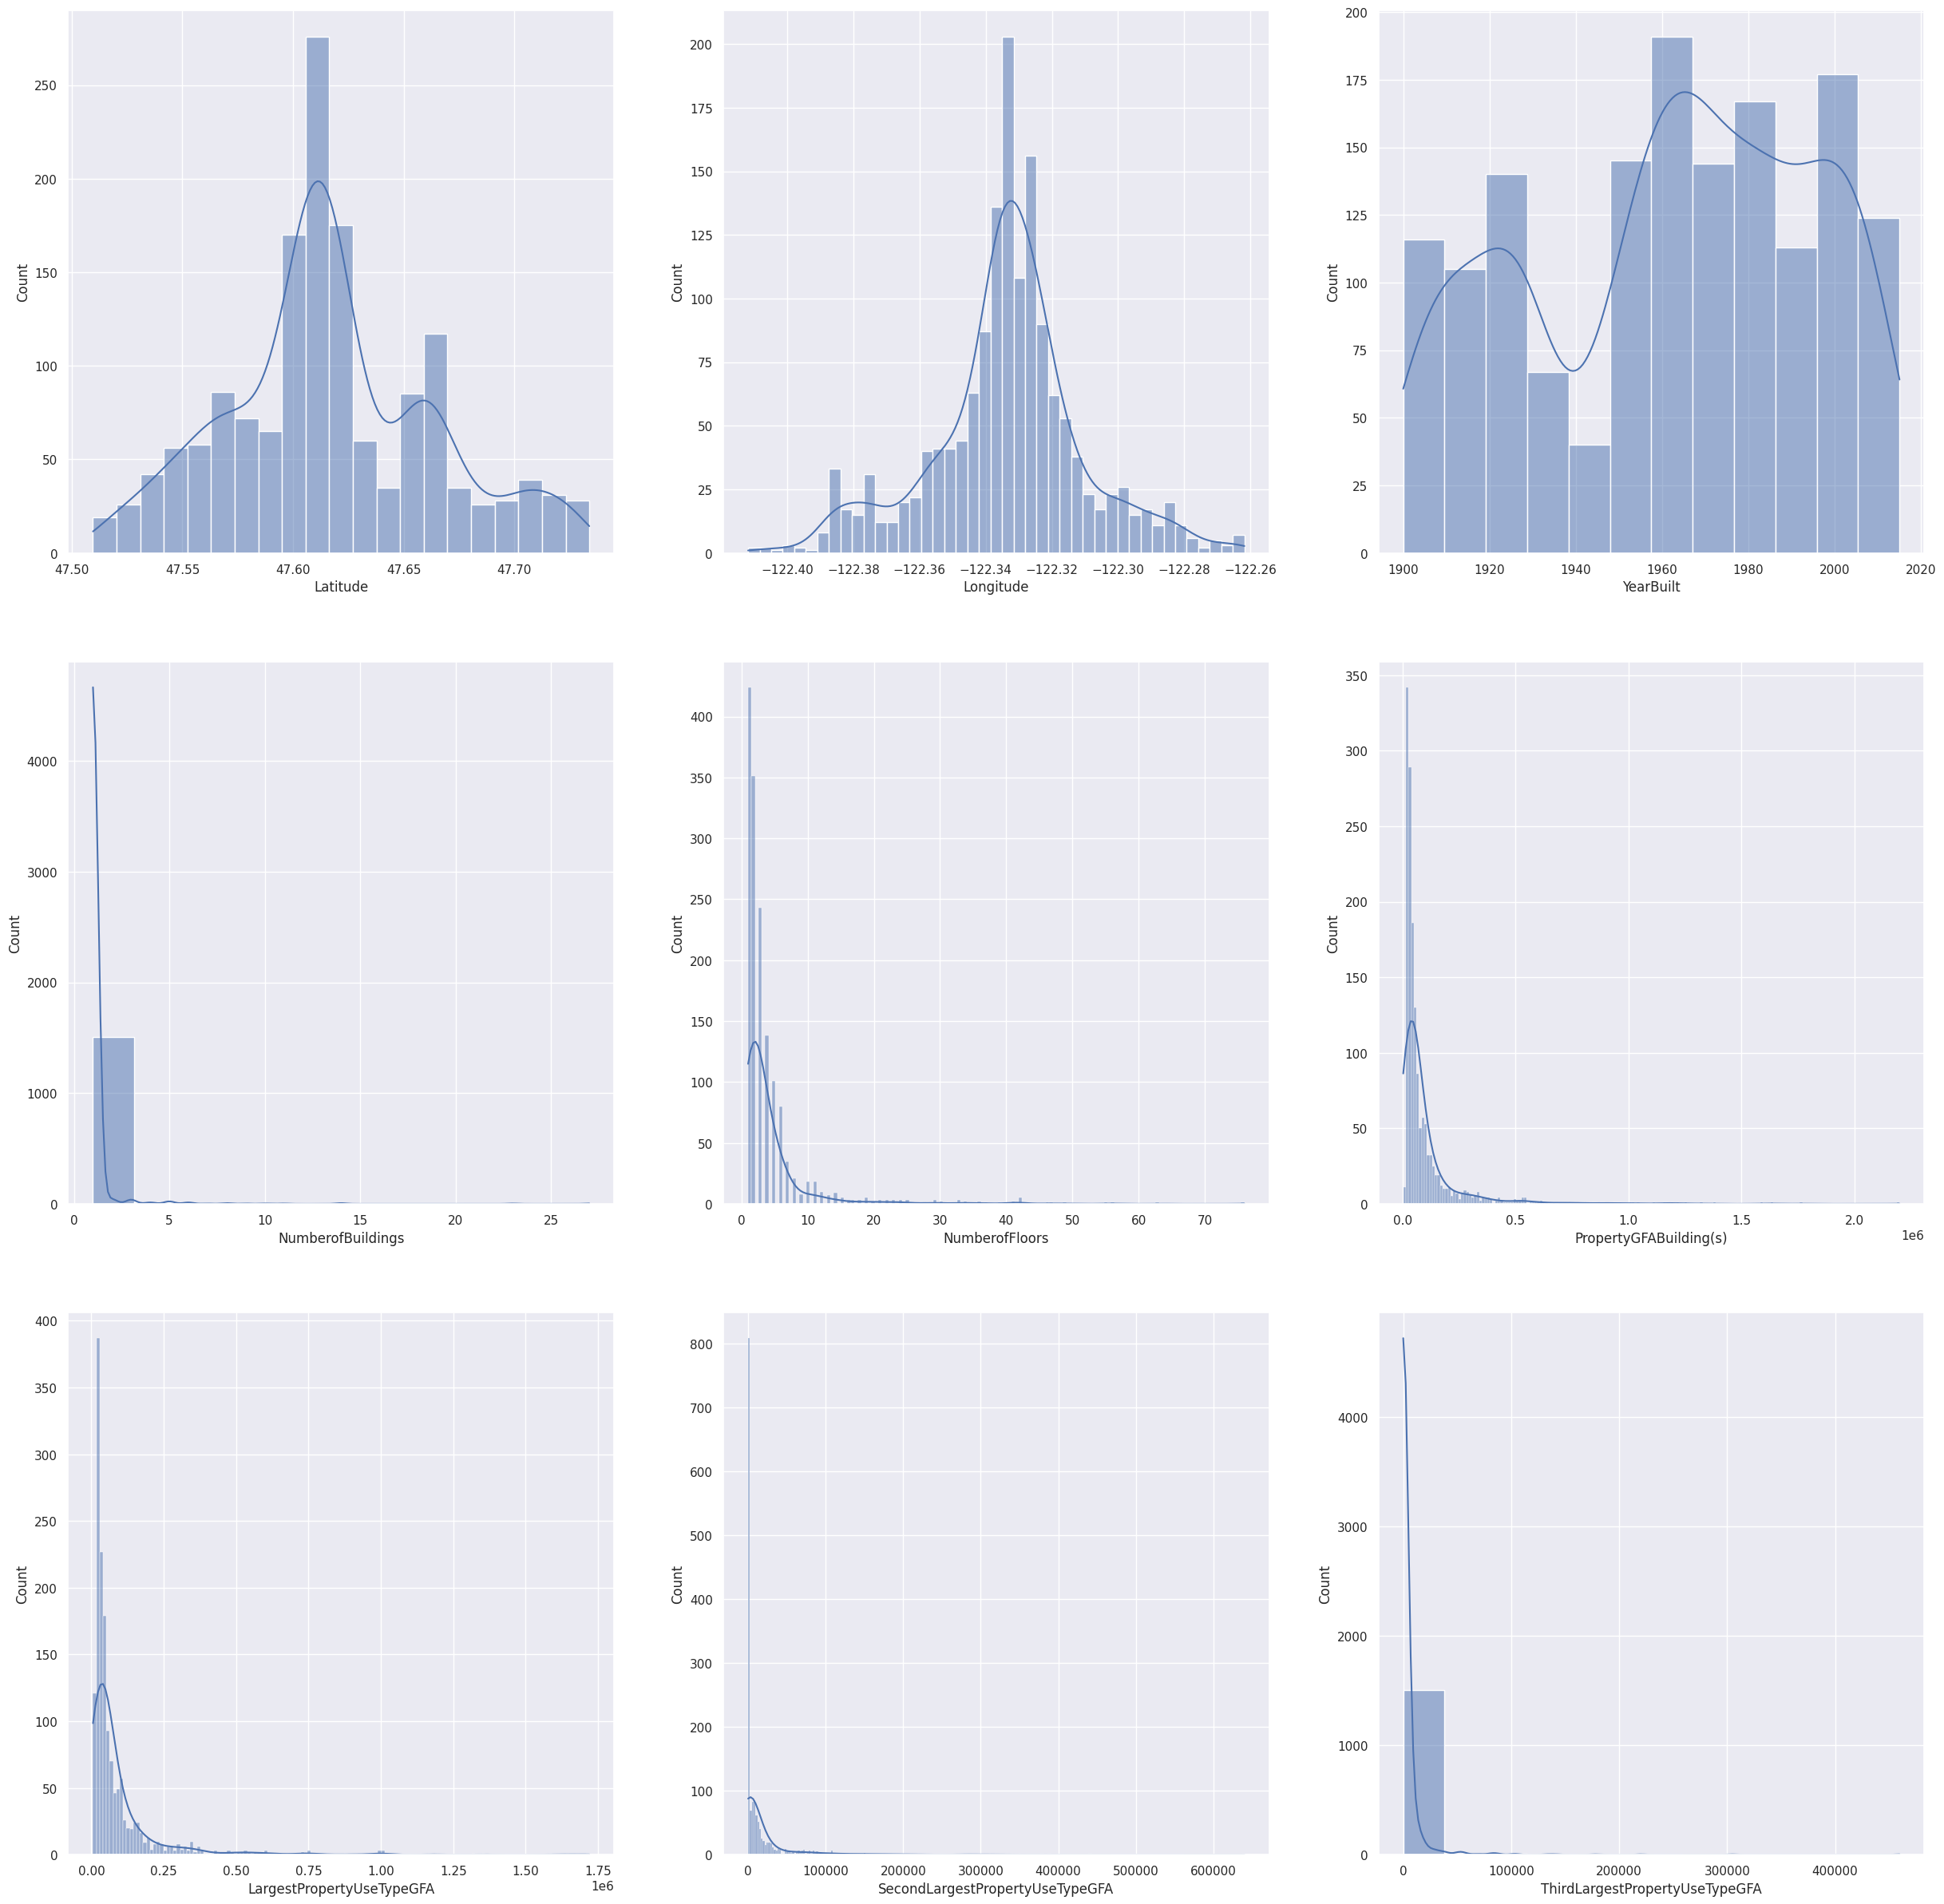

In [14]:
fig, axs = plt.subplots(3,3, figsize=(30,30))
sns.histplot(data=X_scaled, x="Latitude", kde=True, ax=axs[0, 0])
sns.histplot(data=X_scaled, x="Longitude", kde=True, ax=axs[0, 1])
sns.histplot(data=X_scaled, x="YearBuilt", kde=True, ax=axs[0, 2])
sns.histplot(data=X_scaled, x="NumberofBuildings", kde=True, ax=axs[1, 0])
sns.histplot(data=X_scaled, x="NumberofFloors", kde=True, ax=axs[1, 1])
sns.histplot(data=X_scaled, x="PropertyGFABuilding(s)", kde=True, ax=axs[1, 2])
sns.histplot(data=X_scaled, x="LargestPropertyUseTypeGFA", kde=True, ax=axs[2, 0])
sns.histplot(data=X_scaled, x="SecondLargestPropertyUseTypeGFA", kde=True, ax=axs[2, 1])
sns.histplot(data=X_scaled, x="ThirdLargestPropertyUseTypeGFA", kde=True, ax=axs[2, 2])

Pour toutes les variables dont la distribution est très étalée, nous allons appliquer une fonction logarithme afin de réduire leur amplitude.

Nous appliquerons cette transformation à :
- NumberofBuildings
- NumberofFloors
- PropertyGFABuilding(s)
- LargestPropertyUseTypeGFA
- SecondLargestPropertyUseTypeGFA
- ThirdLargestPropertyUseTypeGFA

In [15]:
X_scaled["NumberofBuildings"] = np.log1p(X_scaled["NumberofBuildings"])
X_scaled["NumberofFloors"] = np.log1p(X_scaled["NumberofFloors"])
X_scaled["PropertyGFABuilding(s)"] = np.log1p(X_scaled["PropertyGFABuilding(s)"])
X_scaled["LargestPropertyUseTypeGFA"] = np.log1p(X_scaled["LargestPropertyUseTypeGFA"])
X_scaled["SecondLargestPropertyUseTypeGFA"] = np.log1p(X_scaled["SecondLargestPropertyUseTypeGFA"])
X_scaled["ThirdLargestPropertyUseTypeGFA"] = np.log1p(X_scaled["ThirdLargestPropertyUseTypeGFA"])

Vérifions les distributions après transformation

<Axes: xlabel='ThirdLargestPropertyUseTypeGFA', ylabel='Count'>

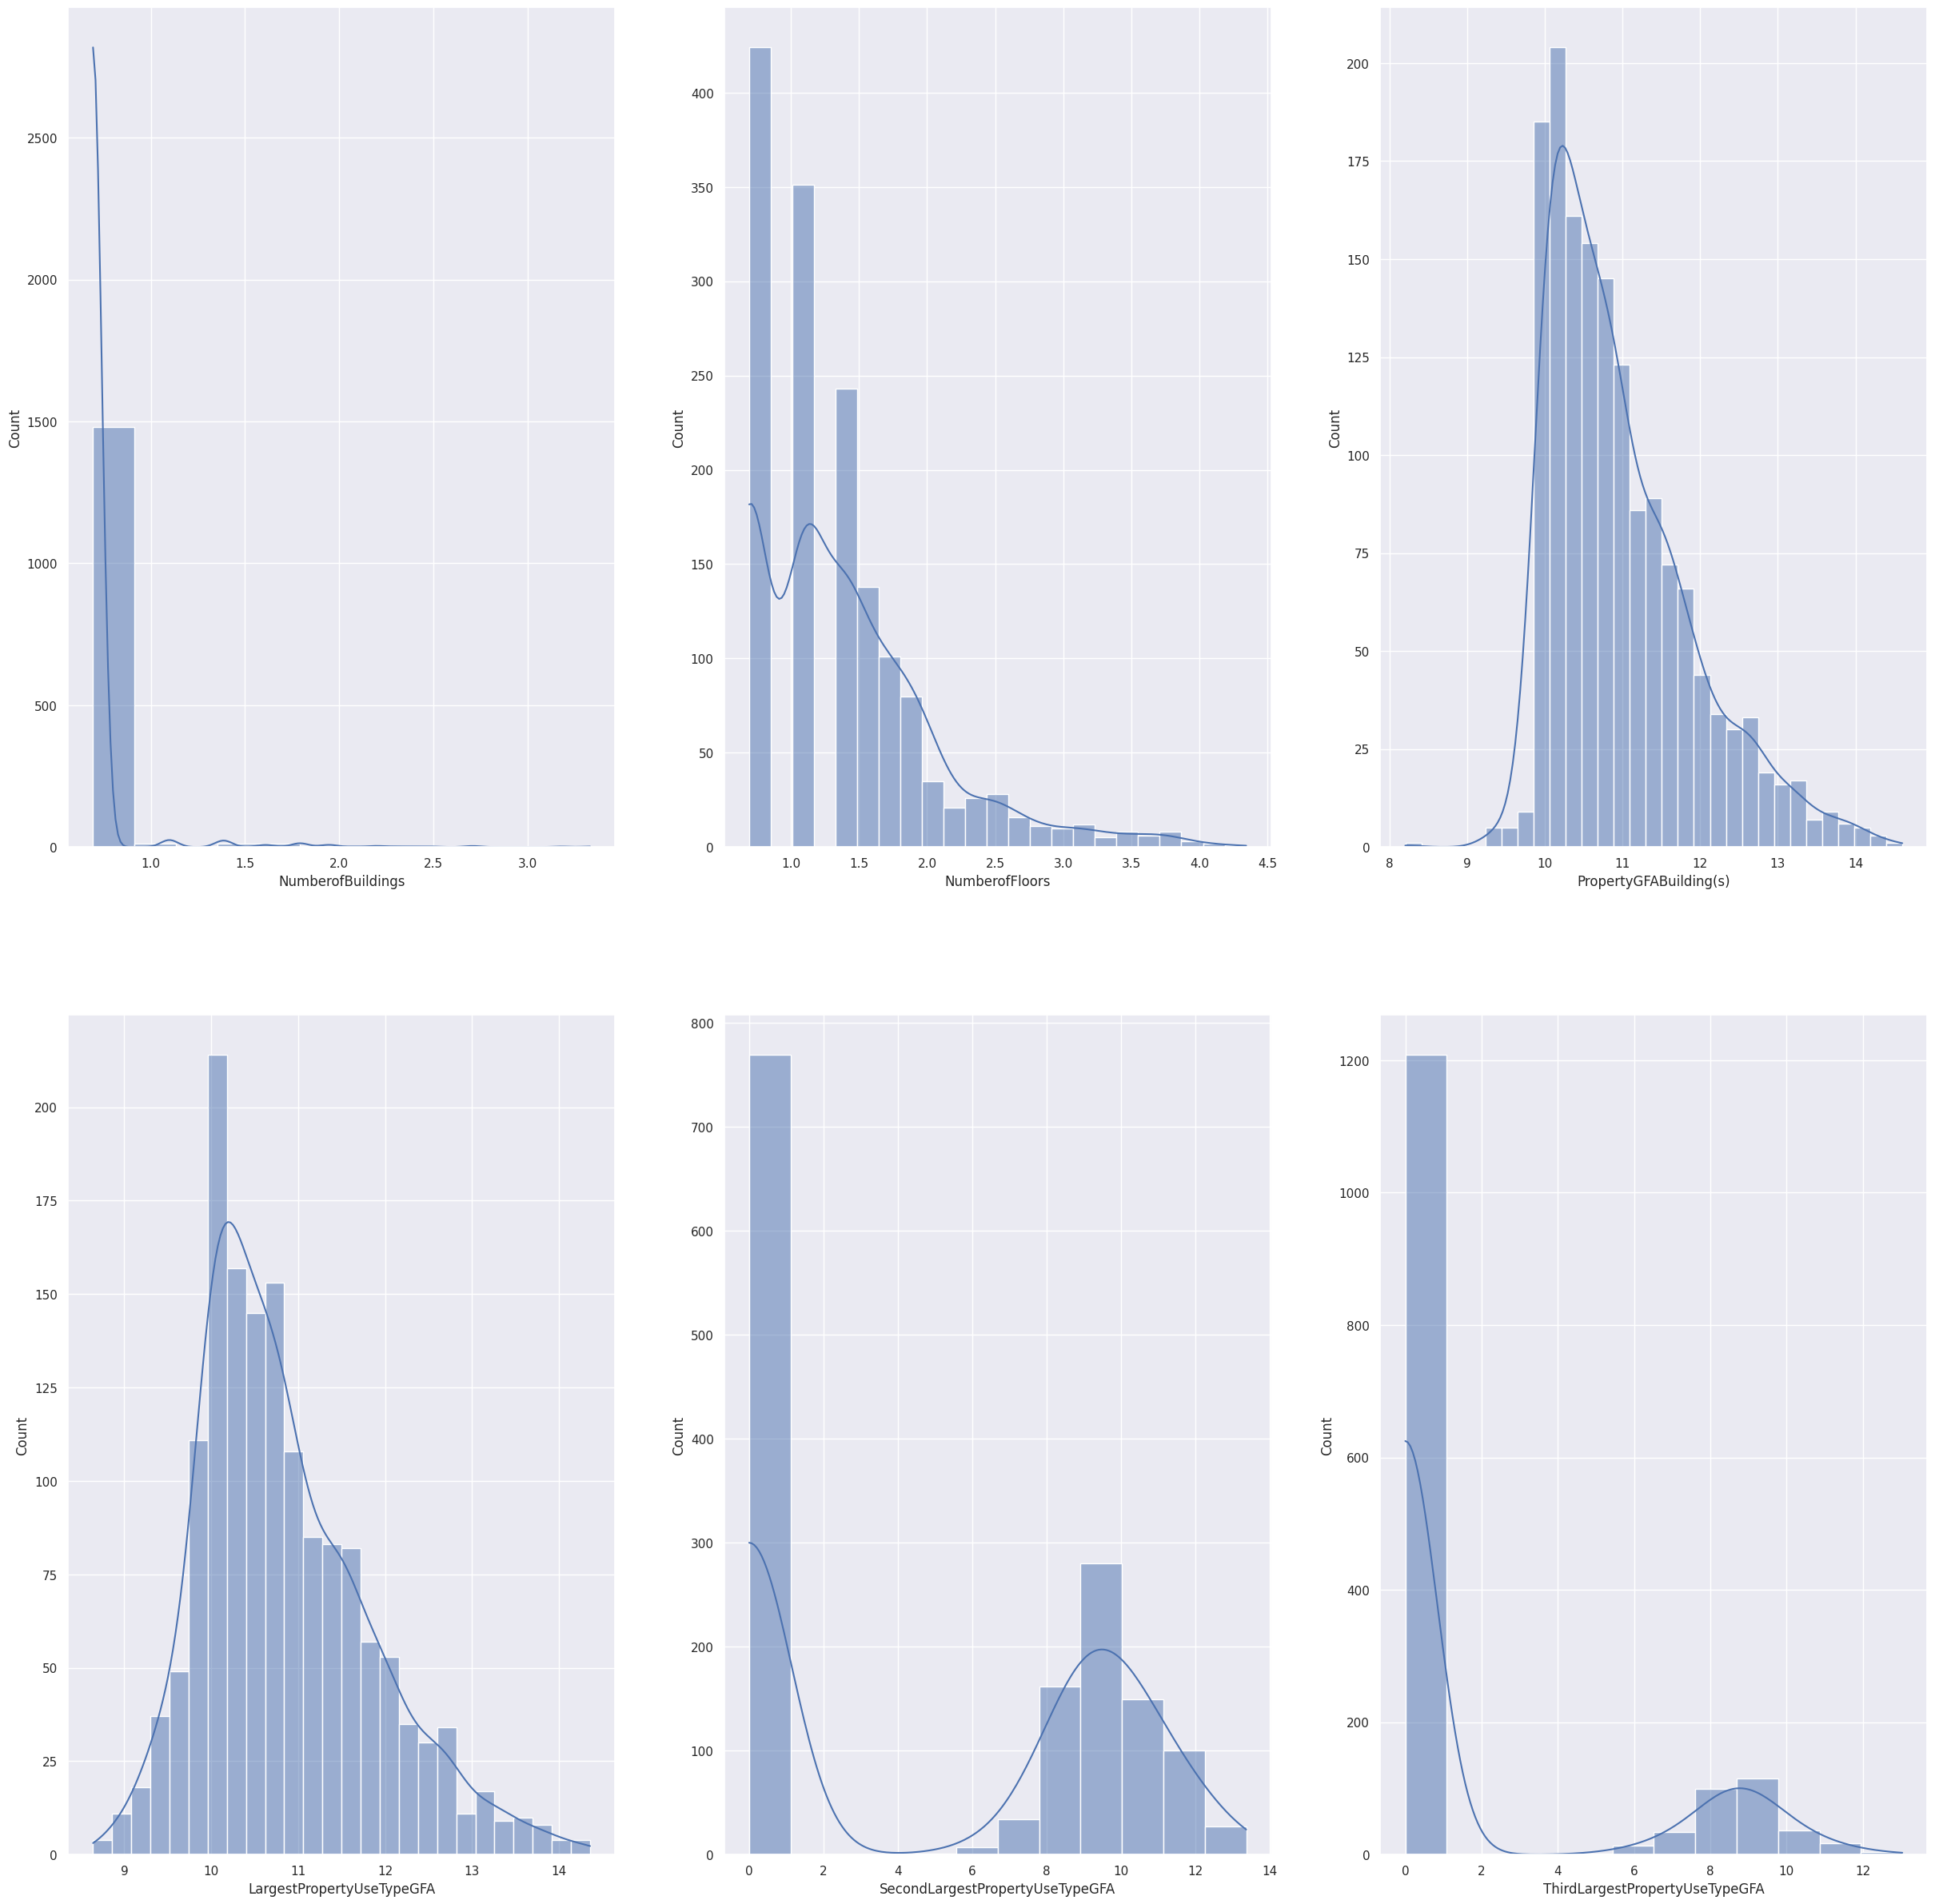

In [16]:
fig, axs = plt.subplots(2,3, figsize=(30,30))
sns.histplot(data=X_scaled, x="NumberofBuildings", kde=True, ax=axs[0, 0])
sns.histplot(data=X_scaled, x="NumberofFloors", kde=True, ax=axs[0, 1])
sns.histplot(data=X_scaled, x="PropertyGFABuilding(s)", kde=True, ax=axs[0, 2])
sns.histplot(data=X_scaled, x="LargestPropertyUseTypeGFA", kde=True, ax=axs[1, 0])
sns.histplot(data=X_scaled, x="SecondLargestPropertyUseTypeGFA", kde=True, ax=axs[1, 1])
sns.histplot(data=X_scaled, x="ThirdLargestPropertyUseTypeGFA", kde=True, ax=axs[1, 2])

Intéressons nous à présent à notre cible.

<Axes: xlabel='SiteEnergyUseWN(kBtu)', ylabel='Count'>

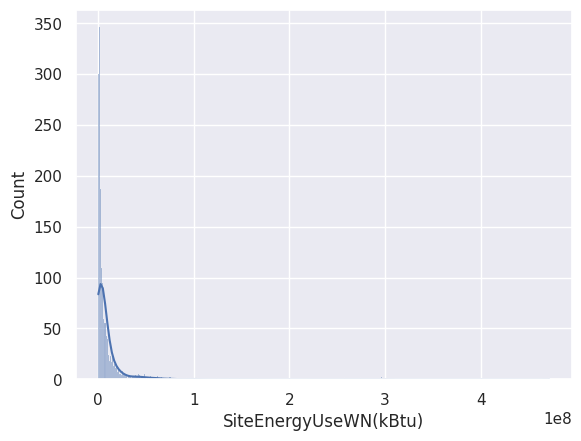

In [17]:
sns.histplot(data=y, kde=True)

La distribution de notre cible est également très étalée à droite. Nous allons également lui appliquer une normalisation à l'aide d'un logarithme.

Attention toutefois, nous devrons utiliser la fonction inverse pour reconvertir nos prédictions dans leur échelle d'origine et avoir des scores représentatifs. Pour cela, nous utiliserons la fonction np.expm1.

In [18]:
y_scaled = np.log1p(y)

<Axes: xlabel='SiteEnergyUseWN(kBtu)', ylabel='Count'>

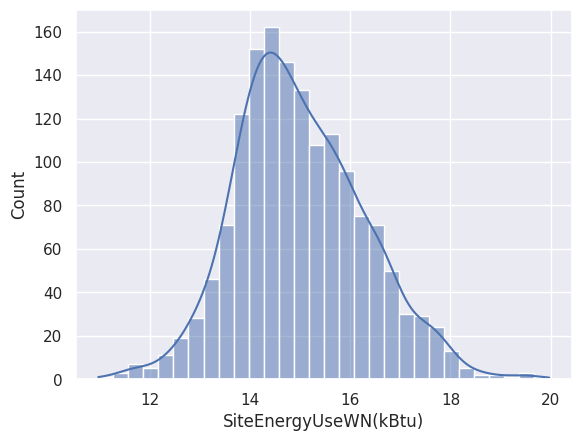

In [19]:
sns.histplot(data=y_scaled, kde=True)

Afin de finaliser la transformation de nos données, nous allons créer un préprocesseur qui sera utilisé dans le pipeline de création de nos modèles. 

Cela aura pour effet d'appliquer les transformation sur nos variables en éliminant le risque de dataleakage, notamment à cause des variables catégorielles, pour lesquelles nous appliquerons un TargetEncoder. En effet, le TargetEncoder utilise les valeurs de la cible pour transformer les catégories, aussi celui-ci devra être effectué pour chacun de nos folds.

Pour effectuer cela, nous utiliserons un ColumnTransformer qui nous permettra d'appliquer un traitement spécifique pour chaque type de colonnes.

En premier lieu, définissons des sélecteurs de colonnes pour séparer nos différents types de données.

In [20]:
quanti_selector = make_column_selector(dtype_include=np.number)
quali_selector = make_column_selector(dtype_include=object)
bool_selector = make_column_selector(dtype_include=np.bool)

Ensuite, nous créons un ColumnTransformer qui applique les transformations à nos variables selon leur type.

In [21]:
preprocesseur = ColumnTransformer(
    transformers = [
        ("quanti", StandardScaler(), quanti_selector),
        ("quali", TargetEncoder(random_state = random_state), quali_selector),
        ("bool", MinMaxScaler(), bool_selector)
    ]
)

# Métriques d'évaluations

Pour la comparaison de nos modèles, nous utiliserons plusieurs métriques d'évaluation ainsi qu'une validation croisée à l'aide de la fonction cross_validate du package sklearn.model_selection.

Tout d'abord la fonction cross_validate nous permet d'évaluer plusieurs métriques à la fois sur notre dataframe. De plus, elle effectue une validation croisée en séparant notre dataframe en plusieurs folds de sets d'entrainement/test.

Pour la validation croisée et étant donné que nous faisons face à de nombreuses variables catégorielles, nous opterons ici pour un StratifiedKFold.

Mettons tout cela en place.

Tout d'abord, implémentons nos métriques de score. Nous utiliserons ici :
- le coefficient de détermination qui nous permettra d'évaluer les performances du modèle
- la RMSE qui nous donnera un ordre de grandeur de l'erreur dans l'unité de notre cible
- le temps d'entrainement (celui-ci est retourné par la fonction cross_validate)

Pour cela, nous devrons adapter les fonctions de scoring à la variable cible exprimée en log en repassant les valeurs de y_scaled et y_pred à l'exponentiel avec la fonction np.expm1

In [22]:
def r2_score_exp(y_true, y_pred) :
    y_true_exp = np.expm1(y_true)  # Revenir à l'échelle d'origine
    y_pred_exp = np.expm1(y_pred)  # Revenir à l'échelle d'origine
    return r2_score(y_true_exp, y_pred_exp)

In [23]:
def rmse_score_exp(y_true, y_pred) :
    y_true_exp = np.expm1(y_true)  # Revenir à l'échelle d'origine
    y_pred_exp = np.expm1(y_pred)  # Revenir à l'échelle d'origine
    return -root_mean_squared_error(y_true_exp, y_pred_exp)

In [24]:
scoring = {"r2": make_scorer(r2_score_exp),
    "rmse": make_scorer(rmse_score_exp)}

Définissons une fonction. Celle-ci prendra en paramètre le modèle à tester, la cible et les features, puis retourner les scores moyens, et le temps d'entrainement moyen

In [25]:
def calcule_scores(modele_, X_, y_) :
    # Implémentons un StratifiedKFold pour séparer nos données en plusieurs folds
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
    # Pour pouvoir utiliser notre cible dans la fonction split, nous devons la catégorisée
    # Pour cela, utilisons la fonction pd.cut sur la cible
    y_cat = pd.cut(y_, bins=5, labels=["1", "2", "3", "4", "5"])
    spl = skf.split(X_, y_cat)
    # Appliquons la fonction cross_validate pour récupérer les scores
    scores = pd.DataFrame(cross_validate(modele_, X_, y_, cv=spl,
                            scoring=scoring,
                            return_train_score=True, return_estimator=True))

    liste_scores = []
    liste_scores.append(scores["fit_time"].mean())
    liste_scores.append(-scores["train_rmse"].mean())
    liste_scores.append(-scores["test_rmse"].mean())
    liste_scores.append(scores["train_r2"].mean())
    liste_scores.append(scores["test_r2"].mean())

    return liste_scores

# DummyRegressor

Dans le but d'avoir une baseline pour nos tests, nous allons tout d'abord utiliser un DummyRegressor sur nos données.

Définissons tout d'abord le pipeline du modèle.

In [26]:
dummy = Pipeline([
    ("preprocesseur", preprocesseur),
    ("modele", DummyRegressor(strategy="mean"))
])

Calculons le score de notre modèle

In [27]:
score_modele = pd.DataFrame(calcule_scores(dummy, X_scaled, y_scaled), 
    index=["Temps d'entrainement", 
        "Score rmse train", 
        "Score rmse test", 
        "Score r2 train", 
        "Score r2 test"])

score_modele

,0
Temps d'entrainement,8.460879e-03
Score rmse train,2.346616e+07
Score rmse test,2.233398e+07
Score r2 train,-5.291814e-02
Score r2 test,-6.999827e-02


# Adaptation des fonctions de score

# Définissons les différentes modèles que nous allons tester

En premier lieu, nous testerons plusieurs modèles simples :
- une régression linéaire
- un BaggingRegressor
- un GradientBoostingRegressor
- une régression Ridge
- une régression Lasso
- un ElasticNet
- un SVR
- une forêt aléatoire

Définissons nos pipelines

In [28]:
linear = Pipeline([
    ("preprocesseur", preprocesseur),
    ("modele", LinearRegression())
])
bagging = Pipeline([
    ("preprocesseur", preprocesseur),
    ("modele", BaggingRegressor(n_estimators=100, random_state=random_state))
])
boosting = Pipeline([
    ("preprocesseur", preprocesseur),
    ("modele", GradientBoostingRegressor(n_estimators=100, random_state=random_state))
])
ridge = Pipeline([
    ("preprocesseur", preprocesseur),
    ("modele", Ridge(random_state=random_state))
])
lasso = Pipeline([
    ("preprocesseur", preprocesseur),
    ("modele", Lasso(random_state=random_state))
])
elasticnet = Pipeline([
    ("preprocesseur", preprocesseur),
    ("modele", ElasticNet(random_state=random_state))
])
svr = Pipeline([
    ("preprocesseur", preprocesseur),
    ("modele", SVR())
])
rfr = Pipeline([
    ("preprocesseur", preprocesseur),
    ("modele", RandomForestRegressor(random_state=random_state))
])

In [29]:
liste_modeles = {"Rég. linéaire": linear, 
    "Bagging": bagging, 
    "Boosting": boosting,
    "Ridge": ridge,
    "Lasso": lasso,
    "ElasticNet": elasticnet,
    "SVR": svr,
    "RandomForestRegressor": rfr}

In [30]:
nom_modeles = []
scores_modeles = []
for nom, modele in liste_modeles.items() :
    nom_modeles.append(nom)
    scores_modeles.append(calcule_scores(modele, X_scaled, y_scaled))

scores_modeles = pd.DataFrame(scores_modeles, index = nom_modeles, columns=["temps_entrainement", 
    "rmse_train", 
    "rmse_test", 
    "r2_train", 
    "r2_test"])

Text(0.5, 0, 'Type de modèle')

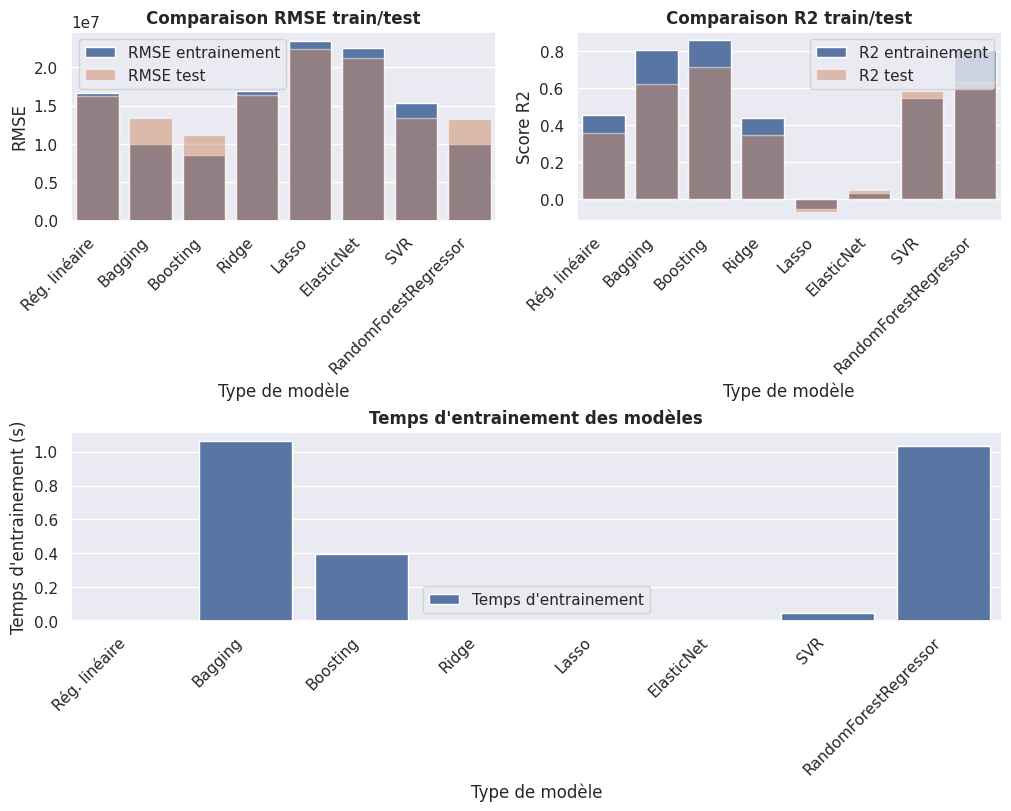

In [31]:
fig = plt.figure(figsize=(10,8), constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=2)

fig_ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(data=scores_modeles, x=scores_modeles.index, y = "rmse_train", label="RMSE entrainement")
sns.barplot(data=scores_modeles, x=scores_modeles.index, y = "rmse_test", label="RMSE test", alpha=0.5)
plt.title("Comparaison RMSE train/test", fontweight="bold")
plt.ylabel("RMSE")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Type de modèle")

fig_ax1 = fig.add_subplot(gs[0, 1])
sns.barplot(data=scores_modeles, x=scores_modeles.index, y = "r2_train", label="R2 entrainement")
sns.barplot(data=scores_modeles, x=scores_modeles.index, y = "r2_test", label="R2 test", alpha=0.5)
plt.title("Comparaison R2 train/test", fontweight="bold")
plt.ylabel("Score R2")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Type de modèle")

fig_ax1 = fig.add_subplot(gs[1, :])
sns.barplot(data=scores_modeles, x=scores_modeles.index, y = "temps_entrainement", label="Temps d'entrainement")
plt.title("Temps d'entrainement des modèles", fontweight="bold")
plt.ylabel("Temps d'entrainement (s)")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Type de modèle")

Parmi tous les modèles testés plusieurs modèles montrent des signes d'overfitting et d'autres de l'underfitting. 

Nous ne sélectionnerons pas les modèles présentant de l'overfitting ou de l'underfitting et nous concentrerons à améliorer les modèles ayant un faible écart entre les résultats de test et d'entrainement.

Parmi ces modèles, la SVR semble être un bon candidat à améliorer. En effet, ces scores RMSE sont parmis les plus bas et son temps d'entrainement est relativement rapide.

Deux autres modèles sont de bons candidats (scores rapprochés, entrainement rapide) :
- Lasso
- ElasticNet

Etant donné que l'ElasticNet combine les pénalités des algorithmes Ridge et Lasso (régularisation L1 et L2), nous choisissons de le tester en second lieu.

# Amélioration de notre modèle

Nous réutiliserons les métriques de scoring définies auparavant dans la variable "scoring"

In [32]:
scoring = {"r2": make_scorer(r2_score_exp),
    "rmse": make_scorer(rmse_score_exp)}

Définissons notre fonction de recherche des hyperparamètres

In [33]:
def evalue_modele(modele_, params_, X_, y_) :
    # Implémentons un StratifiedKFold pour séparer nos données en plusieurs folds
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    # Pour pouvoir utiliser notre cible dans la fonction split, nous devons la catégorisée
    # Pour cela, utilisons la fonction pd.cut sur la cible
    y_cat = pd.cut(y_, bins=6, labels=["1", "2", "3", "4", "5", "6"])
    spl = skf.split(X_, y_cat)
    # Appliquons la fonction GridSearchCV
    algo_ = GridSearchCV(estimator=modele_, param_grid=params_, 
        cv=spl, scoring=scoring, n_jobs=-1, refit="rmse", return_train_score=True)
    
    algo_.fit(X_, y_)
    
    return algo_

Séparons nos données en données d'entrainement et de test

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.2, random_state=random_state)

## SVR

Réutilisons notre pipeline

In [35]:
svr = Pipeline([
    ("preprocesseur", preprocesseur),
    ("modele", SVR())
])

Définissons les paramètres à tester :
- C : Contrôle la pénalisation des erreurs (trade-off entre biais et variance)
- epsilon : Définit une plage où les erreurs sont toélérées sans pénalisation
- kernel : Détermine la transformation des données pour rendre la régression linéaire possible (nous conserverons le kernel par défaut)
- gamma : Contrôle l'influence des points de données individuels

In [36]:
params = [{
    "modele__C": [0.1, 1, 10, 50, 100], 
    "modele__epsilon": [0.01, 0.1, 0.5, 1.0],
    "modele__kernel": ["rbf"],
    "modele__gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1, 10],
}]

Evaluons notre modèle

In [37]:
grid_search = evalue_modele(svr, params, X_train, y_train)

Affichons les paramètres optimaux trouvés par la GridSearch

In [38]:
grid_search.best_params_

{'modele__C': 100,
 'modele__epsilon': 0.1,
 'modele__gamma': 0.001,
 'modele__kernel': 'rbf'}

Récupérons les score associés aux meilleurs paramètres trouvés par la fonction GridSearch

In [39]:
resultats = pd.DataFrame(grid_search.cv_results_)
resultats.iloc[grid_search.best_index_]

mean_fit_time                                                     0.109366
std_fit_time                                                      0.035001
mean_score_time                                                   0.021329
std_score_time                                                    0.001558
param_modele__C                                                      100.0
param_modele__epsilon                                                  0.1
param_modele__gamma                                                  0.001
param_modele__kernel                                                   rbf
params                   {'modele__C': 100, 'modele__epsilon': 0.1, 'mo...
split0_test_r2                                                    0.857172
split1_test_r2                                                    0.376188
split2_test_r2                                                     0.80642
split3_test_r2                                                     0.76883
split4_test_r2           

On peut constater :
- Une RMSE moyenne sur les sets d'entrainement de 9.8M
- Une RMSE moyenne sur les sets de test de 11.18M
- Un R2 moyen sur les sets d'entrainement de 0.821
- Un R2 moyen sur les sets de test de 0.73

Sauvegardons notre modèle

In [40]:
best_model = grid_search.best_estimator_

Calculons les scores du modèle, RMSE et R2 avec la partie des données qui n'a pas été vue par le modèle pour vérifier les scores

In [41]:
# évaluation du modèle pour le set de test
y_test_predict = best_model.predict(X_test)
# racine carrée de l'erreur quadratique moyenne du modèle
rmse = rmse_score_exp(y_test, y_test_predict)
# score du modèle
score = r2_score_exp(y_test, y_test_predict)
print("La performance du Modèle pour le set de Test")
print("--------------------------------------------")
print("l'erreur RMSE est {}".format(-rmse))
print('le score est {}'.format(score))

La performance du Modèle pour le set de Test
--------------------------------------------
l'erreur RMSE est 8397222.101230614
le score est 0.8177355185678609


On constate que le modèle s'est largement amélioré. Les RMSE sont proches, bien que le R2 indique un peu d'overfitting (ce qui s'explique car le modèle a été entrainé avec la RMSE).

Essayons d'utiliser à présent l'ElasticNet

## ElasticNet

Réutilisons notre pipeline

In [42]:
elasticnet = Pipeline([
    ("preprocesseur", preprocesseur),
    ("modele", ElasticNet(random_state=random_state))
])

Définissons les paramètres à tester :
- n_estimators : Le nombre total d'arbres dans le modèle
- learning_rate : La vitesse à laquelle chaque arbre corrige les erreurs
- max_depth : Limite la profondeur des arbres pour éviter le surapprentissage
- min_samples_split : Nombre minimum d'échantillons requis pour diviser un nœud
- min_samples_leaf : Nombre minimum d'échantillons dans une feuille terminale (nœud terminal)
- max_features : Nombre maximum de features utilisées à chaque split
- loss : Fonction de perte à optimiser
- subsample : Fraction des données utilisées pour construire chaque arbre

Réutilisons notre pipeline

In [43]:
params = [{
    "modele__alpha": [0.1, 0.5, 1.0, 5.0, 10.0],
    "modele__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    "modele__max_iter": [5000, 10000, 15000],
    "modele__tol": [1e-3, 1e-4, 1e-5]
}]

Evaluons notre modèle

In [44]:
grid_search2 = evalue_modele(elasticnet, params, X_train, y_train)

Affichons les paramètres optimaux trouvés par la GridSearch

In [45]:
grid_search2.best_params_

{'modele__alpha': 0.1,
 'modele__l1_ratio': 0.1,
 'modele__max_iter': 5000,
 'modele__tol': 1e-05}

Récupérons les score associés aux meilleurs paramètres trouvés par la fonction GridSearch

In [46]:
resultats = pd.DataFrame(grid_search2.cv_results_)
resultats.iloc[grid_search2.best_index_]

mean_fit_time                                                      0.013851
std_fit_time                                                       0.001524
mean_score_time                                                    0.004616
std_score_time                                                     0.001252
param_modele__alpha                                                     0.1
param_modele__l1_ratio                                                  0.1
param_modele__max_iter                                                 5000
param_modele__tol                                                   0.00001
params                    {'modele__alpha': 0.1, 'modele__l1_ratio': 0.1...
split0_test_r2                                                     0.895665
split1_test_r2                                                     0.347613
split2_test_r2                                                     0.826121
split3_test_r2                                                     0.696136
split4_test_

On peut constater :
- Une RMSE moyenne sur les sets d'entrainement de 15.12M
- Une RMSE moyenne sur les sets de test de 13.8M
- Un R2 moyen sur les sets d'entrainement de 0.589
- Un R2 moyen sur les sets de test de 0.625

Sauvegardons notre modèle

In [47]:
best_model2 = grid_search2.best_estimator_

Calculons les scores du modèle, RMSE et R2 avec la partie des données qui n'a pas été vue par le modèle pour vérifier les scores

In [48]:
# évaluation du modèle pour le set de test
y_test_predict = best_model2.predict(X_test)
# racine carrée de l'erreur quadratique moyenne du modèle
rmse = rmse_score_exp(y_test, y_test_predict)
# score du modèle
score = r2_score_exp(y_test, y_test_predict)
print("La performance du Modèle pour le set de Test")
print("--------------------------------------------")
print("l'erreur RMSE est {}".format(-rmse))
print('le score R2 est {}'.format(score))

La performance du Modèle pour le set de Test
--------------------------------------------
l'erreur RMSE est 7296976.317226803
le score est 0.8623688820932846


Le modèle souffre d'underfitting, en effet les scores sont bien meilleurs avec le set de test que le set d'entrainement.

Nous conserverons pour la suite de notre étude le modèle SVR.

# Analyse de la feature importance

## Analyse permutation importance

Cette méthode mesure l'importance des variables en évaluant la dégradation de la performance lorsque les valeurs d'une variable sont permutées.

In [49]:
resultats = permutation_importance(best_model, X_test, y_test, 
                                   scoring="neg_root_mean_squared_error", n_repeats=50, random_state=random_state)

for i in resultats.importances_mean.argsort()[::-1]:  # Trie par importance décroissante
    print(f"{X_test.columns[i]}: Importance moyenne = {resultats.importances_mean[i]:.4f},"
          f" Écart-type = {resultats.importances_std[i]:.4f}")

PropertyGFABuilding(s): Importance moyenne = 0.2626, Écart-type = 0.0199
LargestPropertyUseTypeGFA: Importance moyenne = 0.1997, Écart-type = 0.0194
LargestPropertyUseType: Importance moyenne = 0.0872, Écart-type = 0.0143
PrimaryPropertyType: Importance moyenne = 0.0431, Écart-type = 0.0115
NaturalGas: Importance moyenne = 0.0424, Écart-type = 0.0085
YearBuilt: Importance moyenne = 0.0078, Écart-type = 0.0037
LargestPropertyUseTypeGFAPct: Importance moyenne = 0.0068, Écart-type = 0.0047
BuildingType_is_Nonresidential_COS: Importance moyenne = 0.0062, Écart-type = 0.0029
SteamUse: Importance moyenne = 0.0061, Écart-type = 0.0020
PropertyGFAParkingPct: Importance moyenne = 0.0041, Écart-type = 0.0030
PropertyGFABuilding(s)Pct: Importance moyenne = 0.0041, Écart-type = 0.0030
SecondLargestPropertyUseTypeGFA: Importance moyenne = 0.0025, Écart-type = 0.0022
SecondLargestPropertyUseType: Importance moyenne = 0.0021, Écart-type = 0.0016
Latitude: Importance moyenne = 0.0017, Écart-type = 0.0

Affichons à présent un bar plot avec l'importance moyenne des variables

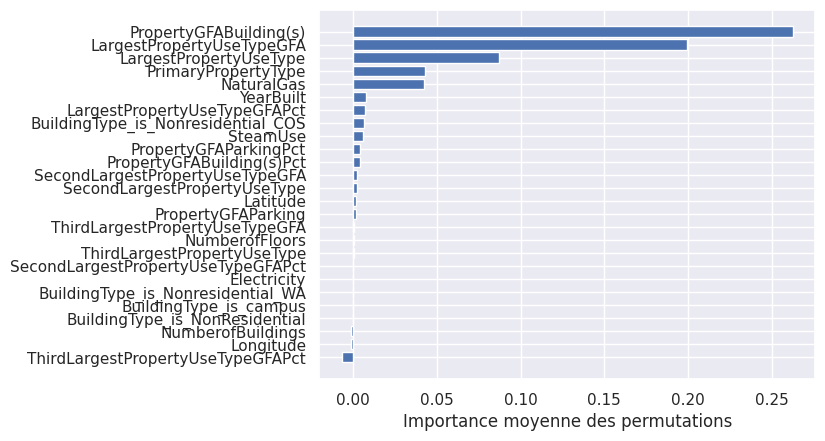

In [50]:
sorted_idx = resultats.importances_mean.argsort()
plt.barh(X_test.columns[sorted_idx], resultats.importances_mean[sorted_idx])
plt.xlabel("Importance moyenne des permutations")
plt.show()

## Analyse SHAP

Initialisons SHAP

In [51]:
shap.initjs()

SHAP nécessite que les données utilisées pour l'analyse soient dans le même format que celles utilisées pour l'entrainement du modèle.

Aussi nous devons transformer les données avec le preprocesseur entrainé avant d'initialiser SHAP.

Récupérons tout d'abord le préprocesseur entrainé

In [52]:
preprocesseur = best_model.named_steps["preprocesseur"]

Transformons les données

In [53]:
feature_names = preprocesseur.get_feature_names_out() 
X_train_transform = preprocesseur.transform(X_train)
X_test_transform = preprocesseur.transform(X_test)

Lors d'une première initiation du KernelExplainer, nous avons eu l'avertissement suivant :

"Using 1223 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples."

Nous allons donc appliquer l'algorithme du kmeans pour réduire la taille de notre échantillon.

In [54]:
X_train_simplifie = shap.kmeans(X_train_transform, 50)

Créons un KernelExplainer en lui donnant le modèle et nos données d'entrainement transformées

In [55]:
explainer = shap.KernelExplainer(best_model.named_steps["modele"].predict, X_train_simplifie)

In [56]:
shap_values = explainer.shap_values(X_test_transform, nsamples=100)

  0%|          | 0/306 [00:00<?, ?it/s]

Affichons l'analyse globale des features

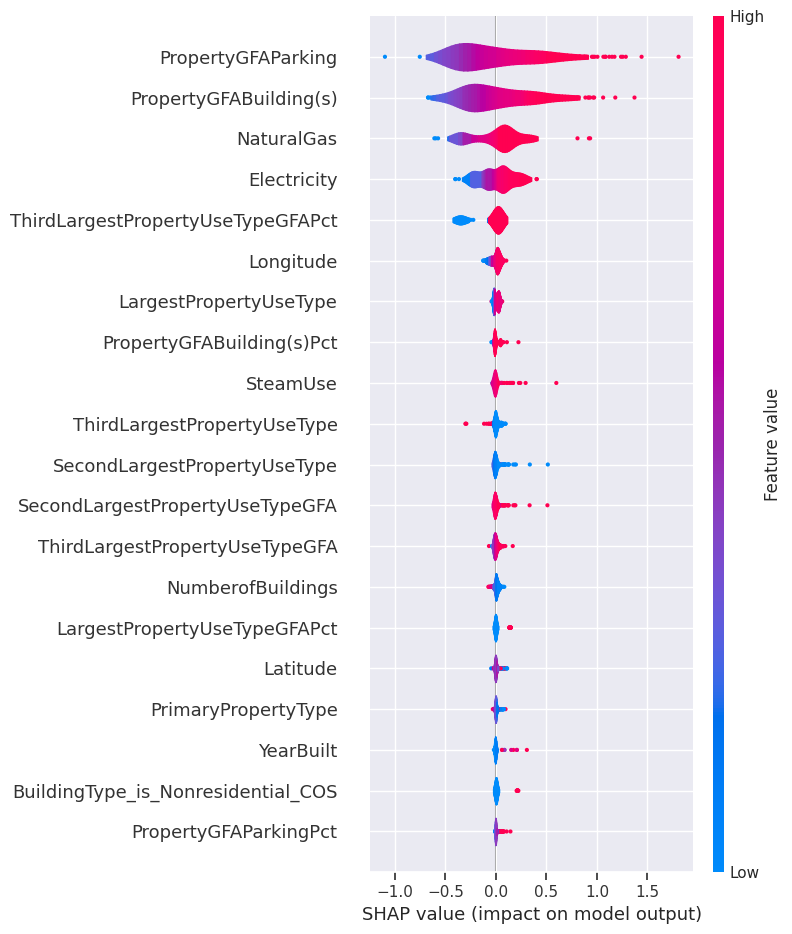

In [57]:
shap.summary_plot(shap_values,
    X_test_transform,
    feature_names=X_train.columns.to_list(),
    plot_type="violin")

Cette analyse explique bien l'importance des features pour notre modèle, on constate que :
- Plus les surfaces de parking et de bâtiment sont grandes, plus le bâtiment émet de CO2.
- Plus le bâtiment utilise d'électricité et de gas naturel, plus le bâtiment émet de CO2.

Cela est corrélé avec la première analyse qui montrait que :
- Les surfaces et types d'utilisation (du bâtiment et de la plus grande utilisation de celui-ci) avaient une importance forte.
- Plus forte est la proportion d'utilisation de gas naturel, plus le bâtiment est émetteur.

# Analyse de l'impact de l'EnergyStarScore

## Feature engineering

Avant d'ajouter l'EnergyStarScore à nos données, analysons sa distribution afin de déterminer par quelle méthode nous allons normaliser ses valeurs

<Axes: xlabel='ENERGYSTARScore', ylabel='Count'>

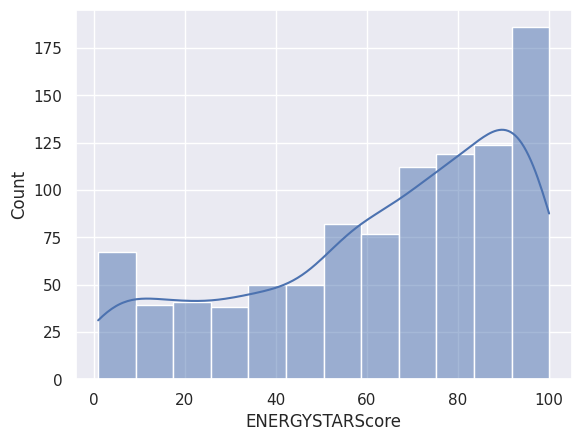

In [58]:
sns.histplot(data=buildings, x="ENERGYSTARScore", kde=True)

Nous appliquerons un StandardScaler à cette variable.

La variable EnergyStarScore a des valeurs manquantes (comme nous l'avons vu lors de l'analyse exploratoire).

Analysons cela plus en détail.

In [59]:
buildings.loc[buildings["ENERGYSTARScore"].isnull(), :].shape[0] * 100 / buildings.shape[0]

35.5788096795291

Etant donné que nous sommes face à 35% de valeurs manquantes, et afin de ne pas pénaliser notre modèle en essayant de combler les valeurs manquantes, nous allons simplement les supprimer

In [60]:
buildings_ES = buildings.loc[~buildings["ENERGYSTARScore"].isnull(), :]

Redéfinissons nos données, en conservant l'EnergyStarScore

In [76]:
X_ES = buildings_ES.drop(["Unnamed: 0",
    "OSEBuildingID",
    "SiteEnergyUseWN(kBtu)",
    "TotalGHGEmissions"], axis=1)
y_ES = buildings_ES["SiteEnergyUseWN(kBtu)"]

Réappliquons les même transformations à nos variables

In [77]:
X_ES_scaled = X_ES

In [78]:
X_ES_scaled["NumberofBuildings"] = np.log1p(X_ES_scaled["NumberofBuildings"])
X_ES_scaled["NumberofFloors"] = np.log1p(X_ES_scaled["NumberofFloors"])
X_ES_scaled["PropertyGFABuilding(s)"] = np.log1p(X_ES_scaled["PropertyGFABuilding(s)"])
X_ES_scaled["LargestPropertyUseTypeGFA"] = np.log1p(X_ES_scaled["LargestPropertyUseTypeGFA"])
X_ES_scaled["SecondLargestPropertyUseTypeGFA"] = np.log1p(X_ES_scaled["SecondLargestPropertyUseTypeGFA"])
X_ES_scaled["ThirdLargestPropertyUseTypeGFA"] = np.log1p(X_ES_scaled["ThirdLargestPropertyUseTypeGFA"])

In [79]:
y_ES_scaled = np.log1p(y_ES)

Nous réutiliserons les métriques de scoring définies auparavant dans la variable "scoring"

In [80]:
scoring = {"r2": make_scorer(r2_score_exp),
    "rmse": make_scorer(rmse_score_exp)}

Définissons notre fonction de recherche des hyperparamètres

In [81]:
def evalue_modele(modele_, params_, X_, y_) :
    # Implémentons un StratifiedKFold pour séparer nos données en plusieurs folds
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    # Pour pouvoir utiliser notre cible dans la fonction split, nous devons la catégorisée
    # Pour cela, utilisons la fonction pd.cut sur la cible
    y_cat = pd.cut(y_, bins=5, labels=["1", "2", "3", "4", "5"])
    spl = skf.split(X_, y_cat)
    # Appliquons la fonction GridSearchCV
    algo_ = GridSearchCV(estimator=modele_, param_grid=params_, 
        cv=spl, scoring=scoring, n_jobs=-1, refit="rmse", return_train_score=True)
    
    algo_.fit(X_, y_)
    
    return algo_

Recréons nos sets d'entrainement et de test

In [82]:
X_ES_train, X_ES_test, y_ES_train, y_ES_test = train_test_split(X_ES_scaled, y_ES_scaled, test_size = 0.2, random_state=random_state)

## Entrainement du modèle

In [83]:
params = [{
    "modele__C": [5, 10, 15, 25, 30, 50], 
    "modele__epsilon": [0.01, 0.1, 0.5, 1.0],
    "modele__kernel": ["rbf"],
    "modele__gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1, 10],
}]

Réutilisons notre pipeline

In [84]:
svr = Pipeline([
    ("preprocesseur", preprocesseur),
    ("modele", SVR())
])

Evaluons notre modèle

In [85]:
grid_search3 = evalue_modele(svr, params, X_ES_train, y_ES_train)

/home/lalende/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Affichons les paramètres optimaux trouvés par la GridSearch

In [86]:
grid_search3.best_params_

{'modele__C': 10,
 'modele__epsilon': 0.1,
 'modele__gamma': 'scale',
 'modele__kernel': 'rbf'}

Récupérons les score associés aux meilleurs paramètres trouvés par la fonction GridSearch

In [87]:
resultats = pd.DataFrame(grid_search3.cv_results_)
resultats.iloc[grid_search3.best_index_]

mean_fit_time                                                     0.036454
std_fit_time                                                      0.008613
mean_score_time                                                   0.011087
std_score_time                                                    0.001837
param_modele__C                                                         10
param_modele__epsilon                                                  0.1
param_modele__gamma                                                  scale
param_modele__kernel                                                   rbf
params                   {'modele__C': 10, 'modele__epsilon': 0.1, 'mod...
split0_test_r2                                                    0.643628
split1_test_r2                                                    0.150105
split2_test_r2                                                     0.98058
split3_test_r2                                                    0.924753
split4_test_r2           

Scores avant intégration de l'ENERGYSTARScore:
- Une RMSE moyenne sur les sets d'entrainement de 9.8M
- Une RMSE moyenne sur les sets de test de 11.18M
- Un R2 moyen sur les sets d'entrainement de 0.821
- Un R2 moyen sur les sets de test de 0.73

On peut constater :
- Une RMSE moyenne sur les sets d'entrainement de 10.4M
- Une RMSE moyenne sur les sets de test de 15.14M
- Un R2 moyen sur les sets d'entrainement de 0.839
- Un R2 moyen sur les sets de test de 0.601

Sauvegardons notre modèle

In [88]:
best_model3 = grid_search3.best_estimator_

Calculons les scores du modèle, RMSE et R2

In [89]:
# évaluation du modèle pour le set de test
y_ES_test_predict = best_model3.predict(X_ES_test)
# racine carrée de l'erreur quadratique moyenne du modèle
rmse = rmse_score_exp(y_ES_test, y_ES_test_predict)
# score du modèle
score = r2_score_exp(y_test, y_test_predict)
print("La performance du Modèle pour le set de Test")
print("--------------------------------------------")
print("l'erreur RMSE est {}".format(-rmse))
print('le score R2 est {}'.format(score))

La performance du Modèle pour le set de Test
--------------------------------------------
l'erreur RMSE est 10745610.767161606
le score est 0.8623688820932846


On constate que lors de la cross validation la RMSE et le R2 ne se sont pas améliorés, voir même sont moins performants.

Cependant, avec le jeu de test les scores sont nettement améliorés, et très cohérents avec les scores d'entrainement de la cross validation.

Nous pouvons donc confirmer que l'ENERGYSTARScore améliore les résultats de notre modèle.